In [1]:
from __future__ import print_function
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.stats import zscore
import seaborn as sns
import sys,os
import gzip
import ftplib
import re
#pd.options.mode.chained_assignment = None  # default='warn'

# Clinical trial cohorts profiled with microarrays
https://support.bioconductor.org/p/36041/ - no way to access phenoData without loading the whole dataset. 
Therefore we download _series_matrix.txt.gz and parse its header. 
Alternative way could be applying getGEO() followed by phenoData(), but this also means downloading the whole dataset. 

# PDX 
RECIST Response Categories

# TCGA
RECIST Response Categories

# GDSC 
- binary 
- continious 

# ToDo:
 - python wrapper for getGEO function
 - automatic download of supplementary files 




In [27]:
nine_drugs = ['Docetaxel', 'Cisplatin', 'Erlotinib', 'Bortezomib','5-Fluorouracil',
         'Tamoxifen', 'Cetuximab', 'Paclitaxel', 'Gemcitabine']

EGFRi_drugs = ['Cetuximab', 'Panitumumab','Erlotinib','Pelitinib','Gefitinib','Lapatinib','Afatinib','ZD-6474']

In [6]:
root_dir = "/home/olya/SFU/Hossein/v2/"
tmp_dir = "/home/olya/SFU/Hossein/arrays/annotations/"

In [7]:
# create folders for training,testing and pre-training in the root_dir  
for folder in ["preprocessed/","preprocessed/annotations/"]:
    if not os.path.exists(root_dir+"/"+folder):
        os.makedirs(root_dir+"/"+folder)

# Clinical trial cohorts
### GSE6434 -  pre-treatmen expression of breast tumours from 24 patients with assessed tumour response to neoadjuvant docetaxel
consists of two subsets GSE349 and GSE350 comprising of resistant (14) and sensitive (10) patients respectively.

In [4]:

resistans_GSE349 = ["GSM4901","GSM4902","GSM4904","GSM4905","GSM4906","GSM4909","GSM4910",
                    "GSM4911","GSM4912","GSM4913","GSM4916","GSM4918","GSM4922","GSM4924"]
sensitive_GSE350 = ["GSM4903","GSM4907","GSM4908","GSM4914","GSM4915","GSM4917","GSM4919",
                    "GSM4920","GSM4921","GSM4923"]

responses_dict = {}
#print("R:",len(resistans_GSE349 ),"S:",len(sensitive_GSE350))
drug = "Docetaxel"
for s in resistans_GSE349:
    responses_dict[s] = {"response":"R","drug":drug,"response_original":"residual tumor of 25% or greater remaining volume"} 
for s in sensitive_GSE350:
    responses_dict[s] = {"response":"S","drug":drug,"response_original":"less than 25% residual tumor"}     
df = pd.DataFrame.from_dict(responses_dict).T
df.index.name = "sample_name"
df.sort_values(by="sample_name",inplace=True)
df.to_csv(root_dir+"/preprocessed/annotations/"+"GSE6434_response."+drug+".tsv",sep = "\t")
print(drug,"R:",df[df["response"]=="R"].shape[0],"S:",df[df["response"]=="S"].shape[0])
df.head()

Docetaxel R: 14 S: 10


,drug,response,response_original
sample_name,,,
GSM4901,Docetaxel,R,residual tumor of 25% or greater remaining volume
GSM4902,Docetaxel,R,residual tumor of 25% or greater remaining volume
GSM4903,Docetaxel,S,less than 25% residual tumor
GSM4904,Docetaxel,R,residual tumor of 25% or greater remaining volume
GSM4905,Docetaxel,R,residual tumor of 25% or greater remaining volume


### GSE18864 - Pretreatment tumor samples from the clinical trial of  cisplatin monotherapy in triple negative breast cancer 
- download matrix file from ftp: 
ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE18nnn/GSE18864/matrix/GSE18864_series_matrix.txt.gz
- parse header
- convert =Miller-Payne response into binary S/R :
    - 5 >=Miller-Payne response > 1 → “Sensitive”;
    - Miller-Payne response == 1 →  “Resistant”;
Miller-Payne response scale is explained here: https://www.researchgate.net/publication/263296704_Correlation_of_clinico-pathologic_and_radiologic_parameters_of_response_to_neoadjuvant_chemotherapy_in_breast_cancer 
- 51 samples without response excluded 

In [8]:
def download_GEO_matrix(fname,ftppath,destination=os.getcwd(),ftp='ftp.ncbi.nlm.nih.gov'):
    ftp = ftplib.FTP(ftp)   
    ftp.login() 
    ftp.cwd(ftppath)
    #ftp.retrlines('LIST')
    file_handle = open(destination+"/"+fname, 'wb')
    ftp.retrbinary('RETR '+fname, file_handle.write)
    file_handle.close()
    ftp.quit()
    return destination+"/"+fname

In [9]:
def millerPayne2RECIST(response):
    try :
        response = int(response)
    except:
        #print(response,file=sys.stderr)
        return response
    if response <= 1:
        return "R"
    elif 5 >= response > 1:
        return "S"
    else:
        print(response,file=sys.stderr)
        return None

def read_matrix(fname,index = "GSM"):
    df = {}
    with gzip.open(fname) as infile:
        for line in infile.readlines():
            if line.startswith("!"):
                line = line.rstrip().replace('"','').split("\t")
                line =  map(lambda x : x.rstrip().lstrip(),line)
                #print(line)
                if line[0] == '!Sample_title':
                    df["title"] = line[1:]
                if line[0] == '!Sample_geo_accession':
                    df["GSM"] = line[1:]
                if line[0] == '!Sample_source_name_ch1':
                    df["source"] = line[1:]
                if line[0] == '!Sample_characteristics_ch1':
                    if ":" in line[1]:
                        sep = ": "
                    elif "=" in line[1]:
                        sep = "= "
                    else:
                        pass
                    field = line[1].split(sep)[0]
                    df[field] = map(lambda x : x.replace(field+sep,"").rstrip().lstrip(),line[1:])
    df=pd.DataFrame.from_dict(df)
    df.set_index(index,drop=True,inplace=True)
    return df

In [13]:
fpath = download_GEO_matrix("GSE18864_series_matrix.txt.gz",'/geo/series/GSE18nnn/GSE18864/matrix/'
                    ,destination=tmp_dir)
df = read_matrix(fpath)
os.remove(fpath)
df["response"] = df["miller-payne response"].apply(millerPayne2RECIST)
df = df[df["response"] != "n/a"]
df["drug"] = ["Cisplatin"]*df.shape[0]
df.index.name = "sample_name"
df.sort_values(by="sample_name",inplace=True)
df = df[["drug","response"]+["miller-payne response","grade","brca genotype","p53 status","er/pr/her2 status"]]
df.to_csv(root_dir+"/preprocessed/annotations/"+"GSE18864_response."+"Cisplatin"+".tsv",sep = "\t")
print("Cisplatin","R:",df[df["response"]=="R"].shape[0],"S:",df[df["response"]=="S"].shape[0])
df.head(5) 

Cisplatin R: 8 S: 16


,drug,response,miller-payne response,grade,brca genotype,p53 status,er/pr/her2 status
sample_name,,,,,,,
GSM467523,Cisplatin,S,3,III,WT,unknown,neg/neg/neg
GSM467524,Cisplatin,S,4,III,WT,MSM,neg/neg/neg
GSM467525,Cisplatin,S,5,III,WT,NSM,neg/neg/neg
GSM467526,Cisplatin,R,1,III,WT,MSM,neg/neg/neg
GSM467527,Cisplatin,S,5,III,BRCA1 germline mutation,MSM,neg/neg/neg


### GSE25065 - response and survival following neoadjuvant taxane-anthracycline chemotherapy in  in HER2-negative invasive breast cancer.
- two taxanes studied: Taxol == Paclitaxel and Taxotere == Docetaxel
- download matrix file from ftp: 
ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE25nnn/GSE25065/matrix/GSE25065_series_matrix.txt.gz
- parse header
- rename drugs and response groups as following:

#### Response "pathologic_response_pcr_rd" and "pathologic_response_rcb_class"
- *pathologic_response_pcr_rd*
    - pCR = pathologic complete response 
    - RD = residual disease
- *pathologic_response_rcb_class*,RCB =  residual cancer burden: 
    - RCB-I is minimal RD
    - RCB-II is moderate RD
    - RCB-III extensive RD 
    - pCR is always RCB-0/I.

In the paper,  pCR+RCB-I group was compared with RCB-II/III and pCR+RCB-I/II with RCB-III

I suggest :
* R = RCB-III
* S = pCR, RCB-I/II
* NA - 63 patients RD without RCB score (excluded)

#### Drugs ('type_taxane')
Paclitaxel == Taxol; Docetaxel == Taxotere

In [7]:
drug_dict = {"Taxol":"Paclitaxel","Taxotere":"Docetaxel"}
def RCB2response(row):
    if row["pathologic_response_pcr_rd"] == "pCR":
        response = "S"
    else:# row["pathologic_response_pcr_rd"] == "RD":
        if row["pathologic_response_rcb_class"] == "RCB-0/I" or row["pathologic_response_rcb_class"] == "RCB-II":
            response = "S"
        elif  row["pathologic_response_rcb_class"] == "RCB-III":
            response = "R"
        else: 
            #print(row["pathologic_response_pcr_rd"],row["pathologic_response_rcb_class"],file = sys.stderr)
            response = "NA"
    #else: 
        #print(row["pathologic_response_pcr_rd"],row["pathologic_response_rcb_class"],file = sys.stderr)
    #    response = "NA"
    return response
fpath = download_GEO_matrix("GSE25065_series_matrix.txt.gz",
                            '/geo/series/GSE25nnn/GSE25065/matrix/',destination=tmp_dir)
df = read_matrix(fpath)
os.remove(fpath)
df.index.name = "sample_name"
cols = [u'age_years', u'chemosensitivity_prediction', u'clinical_ajcc_stage',
       u'clinical_nodal_status', u'clinical_t_stage', u'dlda30_prediction',
       u'drfs_1_event_0_censored', u'drfs_even_time_years', u'er_status_ihc',
       u'erbb2_status', u'esr1_status', u'ggi_class', u'grade', u'her2_status',
       u'pam50_class', u'pr_status_ihc',u'rcb_0_i_prediction', u'sample id', 
       u'set_class', u'source', u'tissue', u'title']
#'type_taxane','pathologic_response_pcr_rd','pathologic_response_rcb_class'

In [8]:
df[["title","pathologic_response_pcr_rd"]].groupby("pathologic_response_pcr_rd").count()

,title
pathologic_response_pcr_rd,
NA,16
RD,140
pCR,42


In [9]:
df[["title","pathologic_response_rcb_class"]].groupby("pathologic_response_rcb_class").count()

,title
pathologic_response_rcb_class,
NA,82
RCB-0/I,32
RCB-II,53
RCB-III,31


In [10]:
df["response"] = df.apply(lambda row : RCB2response(row),axis =1 )
# drop NA response
s = df[df["response"] == "NA"].index.values
print("samples with NA response", df[df["response"] == "NA"].shape[0])
df = df[df["response"] != "NA"]
df["drug"] = df["type_taxane"].apply(lambda x : drug_dict[x])
df = df[["drug","response",'pathologic_response_pcr_rd','pathologic_response_rcb_class','type_taxane'] +
       cols]
for drug in list(set(df["drug"].values)):
    d = df[df["drug"]==drug]
    d.sort_values(by="sample_name",inplace=True)
    d.to_csv(root_dir+"/preprocessed/annotations/"+"GSE25065_response."+drug+".tsv",sep = "\t")
    print(drug,"R:",d[d["response"]=="R"].shape[0],"S:",d[d["response"]=="S"].shape[0])
df.head()

samples with NA response 63
Paclitaxel R: 26 S: 58
Docetaxel R: 5 S: 46


/home/olya/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,drug,response,pathologic_response_pcr_rd,pathologic_response_rcb_class,type_taxane,age_years,chemosensitivity_prediction,clinical_ajcc_stage,clinical_nodal_status,clinical_t_stage,...,grade,her2_status,pam50_class,pr_status_ihc,rcb_0_i_prediction,sample id,set_class,source,tissue,title
sample_name,,,,,,,,,,,,,,,,,,,,,
GSM615632,Docetaxel,S,pCR,NA,Taxotere,41.9,Rx Insensitive,IIB,N1,T2,...,3,P,Basal,P,RCB-0/I,5,SET-Low,USO,breast cancer tumor,5
GSM615634,Docetaxel,S,pCR,NA,Taxotere,47.1,Rx Insensitive,IIA,N0,T2,...,2,N,LumB,P,RCB-0/I,13,SET-Low,USO,breast cancer tumor,13
GSM615635,Docetaxel,S,pCR,NA,Taxotere,43.8,Rx Insensitive,IIIC,N3,T3,...,3,N,LumB,P,RCB-II/III,18,SET-Low,USO,breast cancer tumor,18
GSM615636,Docetaxel,S,pCR,NA,Taxotere,50.8,Rx Sensitive,IIIA,N1,T3,...,3,N,LumB,P,RCB-0/I,20,SET-Low,USO,breast cancer tumor,20
GSM615637,Docetaxel,S,pCR,NA,Taxotere,34.1,Rx Insensitive,IIB,N0,T3,...,3,N,Basal,N,RCB-0/I,23,SET-Low,USO,breast cancer tumor,23


### GSE33072 - resistance to erlotinib (25) and PI3K pathway inhibitors (sorafenib, 37) in non-small cell lung cancer
According to the paper, the main outcome measure is disease control rate (DCR) at 8 weeks.
DC was assessed by radiologists and defined as a CR, PR or SD according to the RECIST.
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4211116/#SD1
#### Sorafenib
 - month-to-progression - 'pfsm (month):ch1'
 - whether DC or not '8_week_disease control_1yes_0no:ch1' and '8-week disease control (1=yes, 0=no):ch1'
 -  sensitive if DC, resistant otherwise


#### Erlotinib
 - whether DC or not - not available neither in GEO phenoData nor in publications
 - month-to-progression - 'progression-free survival time (months):ch1'
 
Geeleher 2014 et al. calcluate Pearson's $r$ between months-to-progression and predicted responses. 

DC at eight weeks was unavailable for erlotinib-treated patients; therefore we used months-to-progression (PFSM) to define resistant and sensitive patients. Since eight weeks is approximately 1.86 months, we assigned patients with months-to-progression < 1.86 as resistant and months-to-progression >= 1.86 as sensitive. This is an uncertain assignment.
Erlotinib-treated patients had DC annotation and were assigned to sensitive if DC, and resistant otherwise. 

In [11]:
#fpath = download_GEO_matrix("GSE33072_series_matrix.txt.gz",
#                            '/geo/series/GSE33nnn/GSE33072/matrix/',destination=tmp_dir)
#df = read_matrix(fpath)
# annotation in GEO is messed up, therefore read phenoData with R GEOquery
df = pd.read_csv("GSE33072_annotation.tsv",sep="\t",index_col=0)
df = df.dropna(subset=["treatment:ch1"])
df_e  = df[df["treatment:ch1"] == "erlotinib"]
df_s  = df[df["treatment:ch1"] == "sorafenib"]
#print("Erlotinib:",df_e.shape[0],"Sorafenib:",df_s.shape[0])
df_s.loc[:,"drug"] = "Sorafenib"
df_s.loc[:,"response"] = "R"
df_s.loc[df_s["8-week disease control (1=yes, 0=no):ch1"] == 1.0, "response"] = "S"
cols_order = ["drug","response",'pfsm (month):ch1',"treatment:ch1",'8_week_disease control_1yes_0no:ch1',
      '8-week disease control (1=yes, 0=no):ch1',
      'pfsc (1=progressed; 0=not progressed):ch1']
df_s = df_s[list(cols_order)+list(df_s.columns.values)]
df_s = df_s.T.drop_duplicates().T
df_s = df_s.dropna(how="all",axis=1)
df_s.index.name = "sample_name"
df_s.sort_values(by="sample_name",inplace=True)
print("Sorafenib","R:",df_s.loc[df_s["response"]=="R",:].shape[0],"S:",
      df_s.loc[df_s["response"]=="S",:].shape[0])
df_s.to_csv(root_dir+"/preprocessed/annotations/"+"GSE33072_response."+"Sorafenib"+".tsv",sep = "\t")
df_s.head(3)

/home/olya/miniconda2/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/olya/miniconda2/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Sorafenib R: 16 S: 23


,drug,response,pfsm (month):ch1,treatment:ch1,8_week_disease control_1yes_0no:ch1,"8-week disease control (1=yes, 0=no):ch1",pfsc (1=progressed; 0=not progressed):ch1,title,geo_accession,status,...,prior_tx_for_mets:ch1,progression-free survival status:ch1,progression-free survival time (months):ch1,race:ch1,randomization_date:ch1,smoking_status:ch1,stage_at_diagnosis:ch1,transition/transversion:ch1,type kras aa change:ch1,type of kras mut:ch1
sample_name,,,,,,,,,,,,,,,,,,,,,
GSM677317,Sorafenib,R,1.6756,sorafenib,NaN,0,1,LM118,GSM677317,Public on Jun 01 2012,...,3,NaN,NaN,White,2008-02-06,Former,IV,Transversion,VAL,GGT12GTT
GSM677322,Sorafenib,S,9.1663,sorafenib,NaN,1,1,LM227,GSM677322,Public on Jun 01 2012,...,2,NaN,NaN,White,2008-05-29,Former,IIIB,Transition,ASP,GGT12GAT
GSM677333,Sorafenib,S,2.7598,sorafenib,NaN,1,1,LM450,GSM677333,Public on Jun 01 2012,...,1,NaN,NaN,White,2009-05-13,Former,IV,Transversion,CYS,GGT12TGT


In [12]:
df_e.loc[:,"drug"] = "Erlotinib"
df_e.loc[:,"response"] = "S"
df_e.loc[df_e['progression-free survival time (months):ch1']< 1.86, "response"] = "R"
df_e = df_e.dropna(how="all",axis=1)
cols_order = ["drug","response",'progression-free survival time (months):ch1',"treatment:ch1","treatment:ch1",
       'progression-free survival status:ch1']
df_e = df_e[list(cols_order)+list(df_e.columns.values)]
df_e = df_e.T.drop_duplicates().T
print("Erlotinib","R:",df_e.loc[df_e["response"]=="R",:].shape[0],"S:",
      df_e.loc[df_e["response"]=="S",:].shape[0])
df_e.index.name = "sample_name"
df_e.sort_values(by="sample_name",inplace=True)
df_e.to_csv(root_dir+"/preprocessed/annotations/"+"GSE33072_response."+"Erlotinib"+".tsv",sep = "\t")
df_e.head(3)

Erlotinib R: 12 S: 13


,drug,response,progression-free survival time (months):ch1,treatment:ch1,progression-free survival status:ch1,title,geo_accession,status,submission_date,last_update_date,...,egfr index:ch1,egfr mutation:ch1,glyc_replaced_by_c_d_v_a:ch1,kras mutation:ch1,kras_mut_codon:ch1,kras_mut_iw:ch1,kras_mut_type:ch1,randomization date:ch1,transition_transversion:ch1,type_kras_aa_change:ch1
sample_name,,,,,,,,,,,,,,,,,,,,,
GSM677318,Erlotinib,S,3.2526,erlotinib,1,LM124,GSM677318,Public on Jun 01 2012,Feb 17 2011,Jun 01 2012,...,0.21,WT,C,Mutant,12,Yes,GGT12TGT,9/27/2007,Transversion,CYS
GSM677321,Erlotinib,S,2.037,erlotinib,1,LM218,GSM677321,Public on Jun 01 2012,Feb 17 2011,Jun 01 2012,...,1.05,WT,V,Mutant,12,Yes,GGT12GTT,4/17/2008,Transversion,VAL
GSM677326,Erlotinib,S,2.0698,erlotinib,1,LM237,GSM677326,Public on Jun 01 2012,Feb 17 2011,Jun 01 2012,...,-0.26,WT,V,Mutant,12,Yes,GGT12GTT,7/24/2008,Transversion,VAL


### GSE9782 - response and survival with bortezomib compared to dexamethasone in patients with multiple myeloma
 - Two arrays HG-U133A(GPL96) and HG-U133B(GPL97) for each patient
 - "characteristics_ch1.1" - Dex - Dexamethasone (76), PS341 - Bortezomib (188) 
 - Response:
     - "characteristics_ch1.7" - PGx_Response : complete response (CR), partial response (PR), minimal response (MR), no change (NC), or PD (progressive disease)

     [from 10.1182/blood-2006-09-044974]
     - "characteristics_ch1.8" - PGx_Responder : R - responder, NR - non-responder
Samples with PGx_Response = IE and PGx_Responder = IE were excluded, because this group was not explined in the text

In [13]:
df_a = pd.read_csv("GSE9782-GPL96_annotation.tsv",sep="\t",index_col=0)
df_a.index.name = "sample_name"
df_a.sort_values(by="sample_name",inplace=True)
df_a = df_a.loc[df_a["characteristics_ch1.8"] != "PGx_Responder = IE",]
df_a.loc[:,"response_detailed"] = df_a["characteristics_ch1.7"].apply(lambda x: x.replace("PGx_Response = ",""))
df_a.loc[df_a["characteristics_ch1.8"]=="PGx_Responder = NR","response"] = "R"
df_a.loc[df_a["characteristics_ch1.8"]=="PGx_Responder = R","response"] = "S"
df_a_dex = df_a[df_a["characteristics_ch1.1"] == "treatment = Dex"]
df_a_dex .loc[:,"drug"] = "Dexamethasone"
df_a_bort = df_a[df_a["characteristics_ch1.1"] == "treatment = PS341"]
df_a_bort.loc[:,"drug"] = "Bortezomib"
print("HG-U133A:","Dexamethasone - ",df_a_dex.shape[0],"\tBortezomib - ",df_a_bort.shape[0])

df_b = pd.read_csv("GSE9782-GPL97_annotation.tsv",sep="\t",index_col=0)
df_b.index.name = "sample_name"
df_b.sort_values(by="sample_name",inplace=True)
df_b = df_b.loc[df_b["characteristics_ch1.8"] != "PGx_Responder = IE",]
df_b.loc[:,"response_detailed"] = df_b["characteristics_ch1.7"].apply(lambda x: x.replace("PGx_Response = ",""))
df_b.loc[df_b["characteristics_ch1.8"]=="PGx_Responder = NR","response"] = "R"
df_b.loc[df_b["characteristics_ch1.8"]=="PGx_Responder = R","response"] = "S"
df_b_dex = df_b[df_b["characteristics_ch1.1"] == "treatment = Dex"]
df_b_dex .loc[:,"drug"] = "Dexamethasone"
df_b_bort = df_b[df_b["characteristics_ch1.1"] == "treatment = PS341"]
df_b_bort.loc[:,"drug"] = "Bortezomib"
print("HG-U133B:","Dexamethasone - ",df_b_dex.shape[0],"\tBortezomib - ",df_b_bort.shape[0])

HG-U133A: Dexamethasone -  70 	Bortezomib -  169
HG-U133B: Dexamethasone -  70 	Bortezomib -  169


In [14]:
cols_order = ["drug","response","response_detailed",'title',u'characteristics_ch1.1',u'characteristics_ch1.7',u'characteristics_ch1.8'] 
df_a_bort = df_a_bort[cols_order+list(df_a_bort.columns.values)].T.drop_duplicates().T
df_a_bort.to_csv(root_dir+"/preprocessed/annotations/"+"GSE9782-GPL96_response."+"Bortezomib"+".tsv",sep = "\t")
print("Bortezomib - GPL96","R:",df_a_bort[df_a_bort["response"]=="R"].shape[0],
      "S:",df_a_bort[df_a_bort["response"]=="S"].shape[0])

df_b_bort = df_b_bort[cols_order+list(df_b_bort.columns.values)].T.drop_duplicates().T
df_b_bort.to_csv(root_dir+"/preprocessed/annotations/"+"GSE9782-GPL97_response."+"Bortezomib"+".tsv",sep = "\t")
print("Bortezomib - GPL97","R:",df_b_bort[df_b_bort["response"]=="R"].shape[0],
      "S:",df_b_bort[df_b_bort["response"]=="S"].shape[0])

df_a_dex = df_a_dex[cols_order+list(df_a_dex.columns.values)].T.drop_duplicates().T
df_a_dex.to_csv(root_dir+"/preprocessed/annotations/"+"GSE9782-GPL96_response."+"Dexamethasone"+".tsv",sep = "\t")
print("Dexamethasone - GPL96","R:",df_a_dex[df_a_dex["response"]=="R"].shape[0],
      "S:",df_a_dex[df_a_dex["response"]=="S"].shape[0])

df_b_dex = df_b_dex[cols_order+list(df_b_dex.columns.values)].T.drop_duplicates().T
df_b_dex.to_csv(root_dir+"/preprocessed/annotations/"+"GSE9782-GPL97_response."+"Dexamethasone"+".tsv",sep = "\t")
print("Dexamethasone - GPL97","R:",df_b_dex[df_b_dex["response"]=="R"].shape[0],
      "S:",df_b_dex[df_b_dex["response"]=="S"].shape[0])

Bortezomib - GPL96 R: 84 S: 85
Bortezomib - GPL97 R: 84 S: 85
Dexamethasone - GPL96 R: 42 S: 28
Dexamethasone - GPL97 R: 42 S: 28


# PDX
Supplementary file nm.3954-S2.xlsx from https://www.nature.com/articles/nm.3954, tab "PCT curve metrics"

- all combinational treatemnts were excluded
- records containing '-->' or '-->-->' signs in ResponseCategory were excluded; these records correspond non-stable response, e.g. PR --> PD means SD-->-->PD means
- we focus on 5 drugs: 'Cetuximab', 'Paclitaxel', 'Gemcitabine', '5-Fluorouracil', 'Erlotinib';
 'Tamoxifen' has no "S" xenografts
 

In [13]:
# add download of annotation file 
df = pd.read_excel("/home/olya/SFU/Hossein/PDX/nm.3954-S2.xlsx","PCT curve metrics")
print(df.shape)
df.drop_duplicates(inplace=True)
print("Combo drugs responses dropped:",df.loc[df["Treatment type"]=="combo",:].shape[0])
df = df.loc[df["Treatment type"]=="single",:]
print(df.shape)
df.head()

(4758, 11)
Combo drugs responses dropped: 1279
(3479, 11)


,Model,Treatment,Treatment target,Treatment type,BestResponse,Day_BestResponse,BestAvgResponse,Day_BestAvgResponse,TimeToDouble,Day_Last,ResponseCategory
0,X-007,BGJ398,FGFR,single,396.5,11,220.475000,11,4.000000,11,PD
1,X-007,BKM120,"PIK3CA,PIK3CB,PIK3CG,PIK3CD,panPI3K",single,189.1,14,77.050000,11,6.207547,14,PD
2,X-007,BYL719,PIK3CA,single,303.7,11,196.175000,11,4.000000,11,PD
5,X-007,CLR457,"PIK3CA,PIK3CB,PIK3CG,PIK3CD,panPI3K",single,25.0,16,26.533333,16,36.835000,37,SD
6,X-007,HDM201,MDM2,single,330.8,11,182.750000,11,4.000000,11,PD


In [ ]:
#df[["Model","Treatment"]].groupby("Treatment").size()

In [ ]:
df[["Model","ResponseCategory"]].groupby("ResponseCategory").size()

In [ ]:
drug_dict = {"5FU":"5-Fluorouracil","erlotinib":"Erlotinib","cetuximab":"Cetuximab",
            "gemcitabine-50mpk":"Gemcitabine","paclitaxel":"Paclitaxel"}
response_dict = {"CR":"S","PR":"S","SD":"R","PD":"R"}

In [ ]:
df = df.loc[df["Treatment"].isin(drug_dict.keys()),:]
print("Records for drugs",drug_dict.values(),df.shape[0])

In [ ]:
df[["Model","Treatment"]].groupby("Treatment").size()

In [ ]:
df = df.loc[~df["ResponseCategory"].str.contains("-->"),:]
df.groupby("ResponseCategory").size()

In [ ]:
df.loc[:,"drug"] = df["Treatment"].apply(lambda x : drug_dict[x])
df.loc[:,"response"] = df["ResponseCategory"].apply(lambda x : response_dict[x])
df = df[["Model","drug","response","ResponseCategory","Treatment","Treatment target",
   "Treatment type","BestResponse","Day_BestResponse","BestAvgResponse","Day_BestAvgResponse","TimeToDouble","Day_Last"]]

for drug in drug_dict.values():
    d = df.loc[df["drug"]==drug,:]
    d.set_index("Model",inplace = True,drop=True)
    d.index.name = "sample_name"
    d.sort_values(by="sample_name",inplace=True)
    d.to_csv(root_dir+"/preprocessed/annotations/"+"PDX_response."+drug+".tsv",sep = "\t")
    print(drug,"R:",d[d["response"]=="R"].shape[0],
      "S:",d[d["response"]=="S"].shape[0])
d.head(3)

# TCGA 

Ding et al. 2016, Supplementary tables , tab "Table S2"

"bcr_patient_barcode" matches with first 12 symbols in sample barcore. One patient in TCGA may have more than one tumor sample and even one or several normal samples. 


In [46]:
response_dict = {'Clinical Progressive Disease':"R",'Complete Response':"S",
                 'Partial Response':"S",'Stable Disease':"R"}

In [52]:
# add download of annotation file 
df = pd.read_excel("/home/olya/SFU/Hossein/TCGA/annotation_Ding2016/bioinfo16_supplementary_tables.xlsx",
                   "Table S2")
df = df.drop_duplicates()
df.drop([0,2],inplace=True)
cols = df.loc[1,:]
df = df.drop(1)
df.columns = cols
df.loc[:,"cohort"] = df["Cancer"].apply(lambda x: re.search(r'\((.*?)\)',x).group(1))
df.loc[:,"response"] =  df["measure_of_response"].apply(lambda x: response_dict[x])
print(df.shape)
dup_indices = df.loc[df[["bcr_patient_barcode",
           "days_to_drug_therapy_start","days_to_drug_therapy_end"]].duplicated(keep=False),:].index.values
df = df[["bcr_patient_barcode","cohort","drug_name","response","measure_of_response",
         "days_to_drug_therapy_start","days_to_drug_therapy_end","DrugBank ID",
         "days_to_initial_pathologic_diagnosis","method_of_sample_procurement",
         "days_to_sample_procurement","days_to_new_tumor_event_after_initial_treatment",
         "additional_pharmaceutical_therapy","new_tumor_event_additional_surgery_procedure",
         "history_of_neoadjuvant_treatment"]]
df.rename({"drug_name":"drug"},axis="columns",inplace=True)
df.head()

(2569, 16)


1,bcr_patient_barcode,cohort,drug,response,measure_of_response,days_to_drug_therapy_start,days_to_drug_therapy_end,DrugBank ID,days_to_initial_pathologic_diagnosis,method_of_sample_procurement,days_to_sample_procurement,days_to_new_tumor_event_after_initial_treatment,additional_pharmaceutical_therapy,new_tumor_event_additional_surgery_procedure,history_of_neoadjuvant_treatment
3,TCGA-OR-A5JM,ACC,Sunitinib,R,Clinical Progressive Disease,378,439,DB01268,0,Surgical Resection,1,72,YES,NO,Yes
4,TCGA-OR-A5JM,ACC,Ketoconazole,R,Clinical Progressive Disease,378,439,DB01026,0,Surgical Resection,1,72,YES,NO,Yes
5,TCGA-OU-A5PI,ACC,Etoposide,R,Stable Disease,69,239,DB00773,0,Surgical Resection,0,351,YES,YES,No
6,TCGA-OU-A5PI,ACC,Doxorubicin,R,Stable Disease,69,239,DB00997,0,Surgical Resection,0,351,YES,YES,No
7,TCGA-OU-A5PI,ACC,Cisplatin,R,Stable Disease,55,239,DB00515,0,Surgical Resection,0,351,YES,YES,No


In [53]:
for group in df.iloc[2:10,0:7].groupby("bcr_patient_barcode"):
    pass
def exclude_combos(df_group):
    if df_group.shape[0] == 1:
        return df_group
    d = df_group.T.to_dict()
    keys_to_remove = set()
    for key in d.keys():
        start = d[key]["days_to_drug_therapy_start"]
        end = d[key]["days_to_drug_therapy_end"]
        #print(key,start,end)
        for key2 in d.keys():
            if key2 != key:
                start2 = d[key2]["days_to_drug_therapy_start"]
                end2 = d[key2]["days_to_drug_therapy_end"]
                if not (end < start2) and not (end2 < start):
                    # if not non-overlapping time intervals
                    keys_to_remove.add(key)
                    keys_to_remove.add(key2)
    #print(list(keys_to_remove))
    return df_group.loc[~df_group.index.isin(keys_to_remove),:]
exclude_combos(group[1])

1,bcr_patient_barcode,cohort,drug,response,measure_of_response,days_to_drug_therapy_start,days_to_drug_therapy_end
12,TCGA-OU-A5PI,ACC,Carboplatin,R,Stable Disease,725,817


In [54]:
df_single = []
for group in df.groupby("bcr_patient_barcode"):
    df_single.append(exclude_combos(group[1]))
df_single = pd.concat(df_single)
print(df_single.shape)
print("Records with combo drugs excluded:",df.shape[0] - df_single.shape[0])
df_single.head()

(785, 15)
Records with combo drugs excluded: 1784


1,bcr_patient_barcode,cohort,drug,response,measure_of_response,days_to_drug_therapy_start,days_to_drug_therapy_end,DrugBank ID,days_to_initial_pathologic_diagnosis,method_of_sample_procurement,days_to_sample_procurement,days_to_new_tumor_event_after_initial_treatment,additional_pharmaceutical_therapy,new_tumor_event_additional_surgery_procedure,history_of_neoadjuvant_treatment
1355,TCGA-05-4402,LUAD,Erlotinib,S,Complete Response,122,122,DB00530,0,Other Method (please specify),0,NaN,NaN,NaN,No
1360,TCGA-05-5425,LUAD,Gefitinib,R,Clinical Progressive Disease,608,669,DB00317,0,Other Method (please specify),31,NaN,NaN,NaN,No
883,TCGA-06-1806,GBM,veliparib,R,Clinical Progressive Disease,81,256,NaN,0,Subtotal Resection,0,256,YES,[Not Available],No
884,TCGA-06-1806,GBM,Cabozantinib,R,Clinical Progressive Disease,293,455,DB08875,0,Subtotal Resection,0,256,YES,[Not Available],No
885,TCGA-06-A5U0,GBM,Temozolomide,R,Clinical Progressive Disease,31,74,DB00853,0,Subtotal Resection,0,100,YES,[Not Available],No


In [50]:
drugs = list(set(['Docetaxel', 'Cisplatin', 'Erlotinib', 'Bortezomib','5-Fluorouracil',
         'Tamoxifen', 'Cetuximab', 'Paclitaxel', 'Gemcitabine'] + EGFRi_drugs))

for drug in drugs:
    d = df_single[df_single["drug"] == drug ]
    print(drug, d.shape[0],"R:",d[d["response"] =="R"].shape[0],"S:",d[d["response"] =="S"].shape[0] )
    if d.shape[0] > 0 :
        d.set_index("bcr_patient_barcode",drop=True,inplace=True)
        d.to_csv(root_dir+"/preprocessed/annotations/"+"TCGA_response."+drug+".tsv",sep = "\t")

Cisplatin 113 R: 19 S: 94
Cetuximab 10 R: 4 S: 6
Gemcitabine 68 R: 43 S: 25
Bortezomib 0 R: 0 S: 0
Tamoxifen 15 R: 3 S: 12
ZD-6474 0 R: 0 S: 0
Gefitinib 2 R: 2 S: 0
5-Fluorouracil 0 R: 0 S: 0
Afatinib 0 R: 0 S: 0
Pelitinib 0 R: 0 S: 0
Panitumumab 0 R: 0 S: 0
Paclitaxel 49 R: 15 S: 34
Docetaxel 21 R: 12 S: 9
Lapatinib 0 R: 0 S: 0
Erlotinib 6 R: 4 S: 2


In [51]:
d.head(3)

1,cohort,drug,response,measure_of_response,days_to_drug_therapy_start,days_to_drug_therapy_end,DrugBank ID,days_to_initial_pathologic_diagnosis,method_of_sample_procurement,days_to_sample_procurement,days_to_new_tumor_event_after_initial_treatment,additional_pharmaceutical_therapy,new_tumor_event_additional_surgery_procedure,history_of_neoadjuvant_treatment
bcr_patient_barcode,,,,,,,,,,,,,,
TCGA-05-4402,LUAD,Erlotinib,S,Complete Response,122,122,DB00530,0,Other Method (please specify),0,NaN,NaN,NaN,No
TCGA-53-7624,LUAD,Erlotinib,R,Clinical Progressive Disease,880,922,DB00530,0,Other Method (please specify),40,NaN,NaN,NaN,No
TCGA-64-5778,LUAD,Erlotinib,R,Clinical Progressive Disease,1174,[Not Available],DB00530,0,Tumor Resection,0,NaN,NaN,NaN,No


# GDSC

###  Continuous response - log(IC50) values 

* Supplementary files from  "A landscape of pharmacogenomic interactions in cancer" by Iorio F et al. Cell. 2016:
TableS4A.xlsx from https://www.cancerrxgene.org/gdsc1000/GDSC1000_WebResources//Data/suppData/TableS4A.xlsx , tab 'TableS4A-IC50s'

* Also, log(IC50) for are available here ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/current_release/v17.3_fitted_dose_response.xlsx
(ln(IC50), these values seem to be just slightly different)

###  Binary response 

*  Supplementary files from  Iorio F et al. 2016
https://www.cancerrxgene.org/gdsc1000/GDSC1000_WebResources///Data/suppData/TableS5C.xlsx

Cell line names were replaced with corresponding COSMIC ids from 
https://www.cancerrxgene.org/gdsc1000/GDSC1000_WebResources//Data/suppData/TableS1E.xlsx

### GDSC - binarized response 

In [15]:
COSMIC_ids = pd.read_excel(tmp_dir+"TableS1E.xlsx")
COSMIC_ids = COSMIC_ids.iloc[2:,[1,2]]
COSMIC_ids = COSMIC_ids.iloc[:-1,]
COSMIC_ids.columns = ["name",'COSMIC']
# 1002 pair, all IDs are unique
#print(COSMIC_ids.shape[0],len(set(COSMIC_ids["name"])),len(set(COSMIC_ids["COSMIC"])))
COSMIC_ids.set_index("name",inplace=True,drop=True)
names2COSMIC = dict(COSMIC_ids["COSMIC"])


In [30]:
df = pd.read_excel(tmp_dir+"TableS5C.xlsx")
df.drop([0,1,2],inplace=True)
df = df.iloc[:,1:]
df.set_index("TableS5C - Binarized Drug IC50s, refers to figure 5",inplace=True,drop=True)
df.columns = df.loc["Screened Compounds:",:].values
df = df.iloc[1:,:]
df.index.name = "cell_line"

IC50_thr = df.iloc[0,:]
IC50_thr.name = "logIC50_threshold"
df =  df.iloc[1:,:]

df.rename(names2COSMIC,axis="index",inplace=True)
drugs = set(nine_drugs+EGFRi_drugs).intersection(set(df.columns.values))
df = df.loc[:,drugs]
df.sort_values(by="cell_line",inplace=True)
df.to_csv(root_dir+"/preprocessed/annotations/"+"GDSC_response."+"all_drugs"+".tsv",sep = "\t")
df.head()


,Cisplatin,Cetuximab,Gemcitabine,Bortezomib,Tamoxifen,Gefitinib,5-Fluorouracil,Afatinib,Paclitaxel,Docetaxel,Lapatinib,Erlotinib
cell_line,,,,,,,,,,,,
683665,R,R,R,R,R,R,S,R,R,R,R,R
683667,R,NaN,R,NaN,R,R,R,R,NaN,R,NaN,NaN
684052,NaN,R,R,NaN,R,NaN,R,NaN,NaN,NaN,NaN,NaN
684055,NaN,S,R,R,R,NaN,R,NaN,R,NaN,R,R
684057,S,R,R,R,R,R,R,R,R,R,R,R


In [32]:
df_ic50 = pd.read_excel(tmp_dir+"TableS4A.xlsx",'TableS4A-IC50s')
df_ic50 = df_ic50.iloc[3:,:]
df_ic50.drop(['TableS4A - Whole set of log(IC50s) across all the screened compounds and cell lines, related to Figure 4'],axis=1,inplace=True)
df_ic50.columns = df_ic50.iloc[0,:].values
df_ic50 = df_ic50.iloc[1:,:]
df_ic50.index = df_ic50.iloc[:,0].values
df_ic50.index.name = "cell_line"
df_ic50 = df_ic50.iloc[:,1:]
df_ic50.sort_values(by="cell_line",inplace=True)
df_ic50.to_csv(root_dir+"/preprocessed/annotations/"+"GDSC_response."+"logIC50.all_drugs"+".tsv",sep = "\t")
df_ic50[list(drugs)].head()


,Cisplatin,Cetuximab,Gemcitabine,Bortezomib,Tamoxifen,Gefitinib,5-Fluorouracil,Afatinib,Paclitaxel,Docetaxel,Lapatinib,Erlotinib
cell_line,,,,,,,,,,,,
683665,2.80727,6.29445,-4.40897,-3.81791,2.96832,1.46485,0.145949,1.49002,-3.64729,-4.91873,2.68418,2.43659
683667,1.75756,NaN,-0.399711,NaN,3.70926,1.17482,3.7722,1.86838,NaN,-6.34303,NaN,NaN
684052,NaN,6.38732,-3.70724,NaN,3.57455,NaN,4.708,NaN,NaN,NaN,NaN,NaN
684055,NaN,4.95212,-2.99645,-3.84107,3.6898,NaN,3.74045,NaN,-0.214086,NaN,3.22649,3.34283
684057,1.13197,6.39356,-2.41002,-4.39987,3.80699,2.15203,1.93716,0.463011,0.0960912,-6.73713,3.57179,3.57179


In [34]:
IC50_thr = IC50_thr[list(drugs)].to_dict()
IC50_thr

{u'5-Fluorouracil': 1.1236,
 u'Afatinib': -0.22156,
 u'Bortezomib': -7.6275,
 u'Cetuximab': 5.144,
 u'Cisplatin': 1.3801,
 u'Docetaxel': -6.897,
 u'Erlotinib': 1.5671,
 u'Gefitinib': -0.05346,
 u'Gemcitabine': -5.9903,
 u'Lapatinib': 1.6257,
 u'Paclitaxel': -5.6772,
 u'Tamoxifen': 2.7296}

In [35]:
df_long = []
for drug in drugs:
    d1 = df_ic50.loc[:,[drug]]
    d1.columns = ["logIC50"]
    d2 = df.loc[:,[drug]]
    d2.columns = ["response"]
    d1.dropna(inplace=True)
    d2.dropna(inplace=True)
    d = pd.concat([d2,d1],axis=1)
    d.loc[:,"drug"] = drug
    d.index.name = "sample_name"
    df_long.append(d)
    if d.shape[0] >0 :
        d.to_csv(root_dir+"/preprocessed/annotations/"+"GDSC_response."+drug+".tsv",sep = "\t")
    print(drug,"total:",d.shape[0],"R:",d.loc[d["logIC50"]>IC50_thr[drug],:].shape[0],
          "S:",d.loc[d["logIC50"]<=IC50_thr[drug],:].shape[0])

/home/olya/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Cisplatin total: 850 R: 771 S: 79
Cetuximab total: 873 R: 749 S: 124
Gemcitabine total: 870 R: 815 S: 55
Bortezomib total: 402 R: 371 S: 31
Tamoxifen total: 928 R: 820 S: 108
Gefitinib total: 846 R: 727 S: 119
5-Fluorouracil total: 916 R: 822 S: 94
Afatinib total: 849 R: 696 S: 153
Paclitaxel total: 402 R: 376 S: 26
Docetaxel total: 850 R: 784 S: 66
Lapatinib total: 398 R: 337 S: 61
Erlotinib total: 372 R: 308 S: 64


In [36]:
df_long = pd.concat(df_long)
df_long.loc[:,"logIC50"] = df_long["logIC50"].apply(np.float)
df_long.head()

,response,logIC50,drug
sample_name,,,
683665,R,2.807269,Cisplatin
683667,R,1.757559,Cisplatin
684057,S,1.131967,Cisplatin
684059,S,0.877124,Cisplatin
684062,S,1.342990,Cisplatin


### log(IC50) in R and S groups 

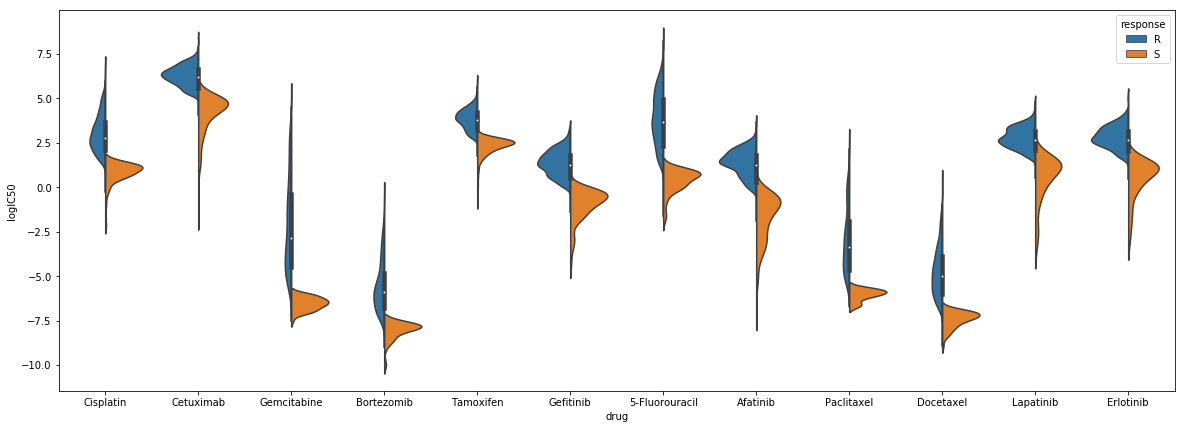

In [37]:
plt.figure(figsize=(20,7))
sns.violinplot(x="drug", y="logIC50", hue="response",data=df_long,split=True)
# this curve fitting is imprecize
#sns.swarmplot(x="drug", y="logIC50", hue="response",data=df_long)

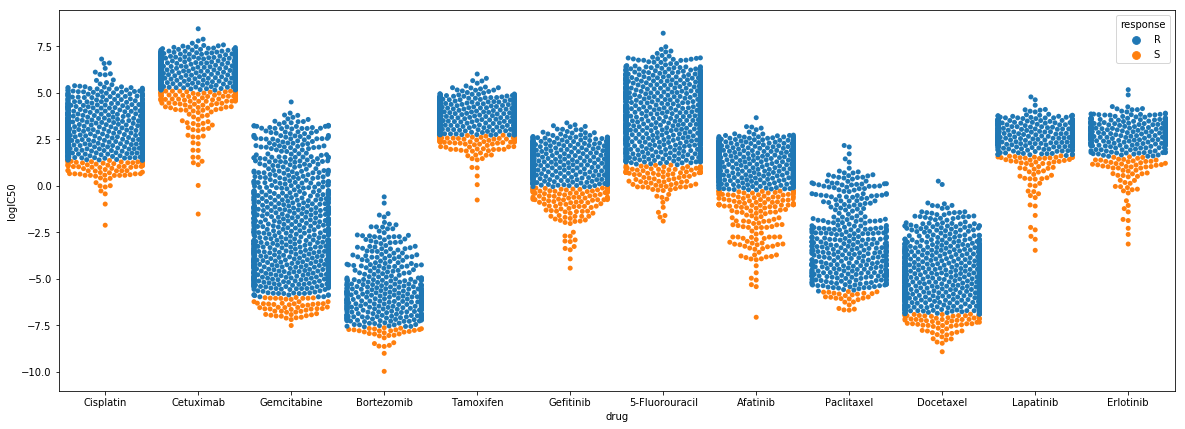

In [38]:
plt.figure(figsize=(20,7))
sns.swarmplot(x="drug", y="logIC50", hue="response",data=df_long)

# CCLE 

#### Problems : 
"GSM886946":"COLO-699" and "GSM887546":"RPMI 6666" are absent in annotation

drug response data:
wget https://data.broadinstitute.org/ccle_legacy_data/pharmacological_profiling/CCLE_NP24.2009_Drug_data_2015.02.24.csv

cell line annotation:
wget https://data.broadinstitute.org/ccle_legacy_data/cell_line_annotations/CCLE_sample_info_file_2012-10-18.txt

expression annotation
wget  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE36nnn/GSE36133/matrix/GSE36133_series_matrix.txt.gz


#### Drugs 
"Paclitaxel","Erlotinib"

Targeted EGFRi : 'Erlotinib', 'Lapatinib', 'ZD-6474'




In [39]:
fpath = download_GEO_matrix("GSE36133_series_matrix.txt.gz",'/geo/series/GSE36nnn/GSE36133/matrix/'
                    ,destination=tmp_dir)
df = read_matrix(fpath)
df.head()

,histology,histology subtype1,primary site,source,title
GSM,,,,,
GSM886835,glioma,astrocytoma,central_nervous_system,ECACC,1321N1
GSM886836,osteosarcoma,,bone,ATCC,143B
GSM886837,carcinoma,,prostate,ATCC,22Rv1
GSM886838,carcinoma,adenocarcinoma,stomach,DSMZ,23132/87
GSM886839,glioma,astrocytoma_Grade_IV,central_nervous_system,DSMZ,42-MG-BA


In [40]:
anno = pd.read_csv(root_dir+ "/preprocessed/annotations/CCLE_sample_info_file_2012-10-18.txt",sep = "\t")
anno = anno[["CCLE name","Cell line primary name"]]
anno.set_index("Cell line primary name",drop=True,inplace=True)
CCLE_names_dict = anno.to_dict()['CCLE name']
#CCLE_names_dict 

In [41]:
mapped_CCLE_names = set(df["title"].values).intersection(set(CCLE_names_dict.keys()))
not_mapped_CCLE_names = set(df["title"].values).difference(set(CCLE_names_dict.keys()))
not_mapped_GSM = set(df["title"].values).difference(set(CCLE_names_dict.keys()))
len(CCLE_names_dict.keys()), len(mapped_CCLE_names), len(set(df["title"].values)), len(set(CCLE_names_dict.keys())),not_mapped_CCLE_names

(1046, 915, 917, 1046, {'COLO-699', 'RPMI 6666'})

In [42]:
df = df.loc[df["title"].isin(mapped_CCLE_names ),:]
df["CCLE_name"] = df["title"].apply(lambda x: CCLE_names_dict[x]) #df["title"] +"_" + df["primary site"].apply(str.upper)
df.to_csv(root_dir+ "/preprocessed/annotations/CCLE_expessions.annotations.tsv",sep = "\t")
df.head()

,histology,histology subtype1,primary site,source,title,CCLE_name
GSM,,,,,,
GSM886835,glioma,astrocytoma,central_nervous_system,ECACC,1321N1,1321N1_CENTRAL_NERVOUS_SYSTEM
GSM886836,osteosarcoma,,bone,ATCC,143B,143B_BONE
GSM886837,carcinoma,,prostate,ATCC,22Rv1,22RV1_PROSTATE
GSM886838,carcinoma,adenocarcinoma,stomach,DSMZ,23132/87,2313287_STOMACH
GSM886839,glioma,astrocytoma_Grade_IV,central_nervous_system,DSMZ,42-MG-BA,42MGBA_CENTRAL_NERVOUS_SYSTEM


In [43]:
ccle_exprs = pd.read_csv(root_dir+"/preprocessed/exprs/GSE36133.BrainArray.RMAlog2Average.ENTREZID.Expr.tsv", sep ="\t")
samples_annotated = set(ccle_exprs.columns.values).intersection(set(df.index.values))
#df.loc[samples_annotated ,"CCLE_name"].to_dict()
ccle_exprs = ccle_exprs.loc[:,samples_annotated]
ccle_exprs.rename(df.loc[samples_annotated ,"CCLE_name"].to_dict(),axis="columns",inplace=True)
ccle_exprs.sort_index(inplace = True)
ccle_exprs.sort_index(inplace = True,axis=1)
#ccle_exprs.to_csv(root_dir+"/preprocessed/exprs/GSE36133.BrainArray.RMAlog2Average.ENTREZID.Expr_renamed.tsv",sep ="\t")
ccle_exprs.head()

,1321N1_CENTRAL_NERVOUS_SYSTEM,143B_BONE,22RV1_PROSTATE,2313287_STOMACH,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,639V_URINARY_TRACT,647V_URINARY_TRACT,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,769P_KIDNEY,...,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,YMB1_BREAST,ZR751_BREAST,ZR7530_BREAST
1,5.899963,5.495630,4.915154,4.386444,8.018313,4.440586,7.108326,4.974334,7.542390,4.769888,...,4.750698,4.899243,4.071518,4.630944,4.617563,7.214694,5.955572,8.455509,7.726960,6.890627
2,4.151092,4.867485,4.683452,3.770537,3.992411,3.668579,3.643959,3.799457,3.985218,3.708740,...,3.532178,4.184472,3.778447,3.898891,4.298302,4.583785,3.854023,4.372195,3.680397,4.555957
9,7.937206,7.653808,10.551317,9.345134,8.158181,7.965484,7.525776,8.514274,8.230191,8.323116,...,7.935024,7.825549,8.277187,8.173469,7.360998,7.899128,7.668647,9.483785,11.846274,9.143848
10,4.153359,4.368691,4.320320,4.784488,4.429411,4.048702,4.131885,4.547273,4.425889,4.545985,...,4.516905,4.596316,4.187752,4.478969,4.309859,4.176227,4.356414,5.568482,5.570161,4.547440
12,5.064883,4.265396,4.796432,7.778202,4.424837,5.518264,4.346809,4.667569,4.214931,5.945018,...,6.669781,4.458947,4.778975,6.045139,5.961929,4.457785,4.843793,5.031419,7.130748,5.497614


In [44]:
response = pd.read_csv(root_dir+"/preprocessed/annotations/"+"CCLE_NP24.2009_Drug_data_2015.02.24.csv",sep=",")
set(response["Compound"].values)
response_9drugs = response.loc[response["Compound"].isin(["Paclitaxel","Erlotinib"]),:]
response_EGFR = response.loc[response["Compound"].isin(['Erlotinib', 'Lapatinib', 'ZD-6474']),:]
response_9drugs.set_index("CCLE Cell Line Name",inplace=True)
response_9drugs.index.name = "CCLE_name"
response_9drugs.to_csv(root_dir+"/preprocessed/annotations/"+"CCLE.responses.Paclitaxel_Erlotinib.tsv", sep = "\t")
response_EGFR.set_index("CCLE Cell Line Name",inplace=True)
response_EGFR.index.name = "CCLE_name"
response_EGFR.to_csv(root_dir+"/preprocessed/annotations/"+"CCLE.responses.EGFRi.tsv", sep = "\t")